In [1]:
import pandas as pd
import numpy as np
import re

In [29]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Methods

In [3]:
# code copied from https://www.kaggle.com/marknagelberg/rmsle-function
def rmsle(y_pred, y_test) : 
    assert len(y_test) == len(y_pred)
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_test))**2))

In [4]:
# Gets the count of most frequent words give a dataframe
def word_freq(df, col):
    word_frequency = {}
    word_frequency_lst = []
    for index,row in df.iterrows(): 
        for w in list(set(row[col].split(' '))):
            if w not in word_frequency:
                word_frequency[w] = 1
            else:
                word_frequency[w] += 1

    for key, value in word_frequency.items():
        temp = [key, value]
        word_frequency_lst.append(temp)
    word_freq_df = pd.DataFrame(word_frequency_lst, columns=["unique_word", 'frequency'])
    word_freq_df = word_freq_df.sort_values(['frequency'], ascending=False)
    return word_freq_df

# Read Data

In [ ]:
unclean_train_data_v3 = pd.read_csv(
    '/Users/joashc/Downloads/mercari-price-suggestion-challenge/partially_clean_train_data.csv')
unclean_train_data_v3.shape

# Model Preparation

## Benchmark Model
- Randomly output prices based on the distribution of price

In [98]:
# describing price
unclean_train_data_v3.price.describe()

count    1.482486e+06
mean     2.673804e+01
std      3.858658e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [101]:
# describing price removing 0.05 and 0.95 percentiles
unclean_train_data_v3[(unclean_train_data_v3['price']>unclean_train_data_v3['price'].quantile(0.05)) &
                  (unclean_train_data_v3['price']<unclean_train_data_v3['price'].quantile(0.95))].price.describe()

count    1.307451e+06
mean     2.182643e+01
std      1.397454e+01
min      6.500000e+00
25%      1.200000e+01
50%      1.700000e+01
75%      2.800000e+01
max      7.400000e+01
Name: price, dtype: float64

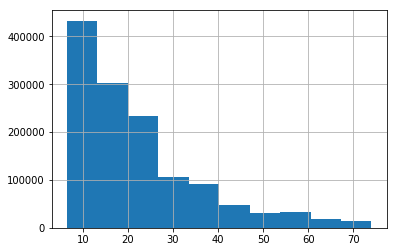

In [103]:
# histogram of price removing 0.05 and 0.95 percentiles
unclean_train_data_v3[(unclean_train_data_v3['price']>unclean_train_data_v3['price'].quantile(0.05)) &
                  (unclean_train_data_v3['price']<unclean_train_data_v3['price'].quantile(0.95))].price.hist()

### Benchmark Model 1

In [165]:
mean = unclean_train_data_v3.price.mean()
std_dev = unclean_train_data_v3.price.std()
print('The mean and standard deviation are:', round(mean,2), ',',round(std_dev,2))

The mean and standard deviation are: 26.74 , 38.59


In [166]:
price_prediction = pd.DataFrame(
    np.random.normal(mean, std_dev, unclean_train_data_v3.shape[0]), columns=['price_prediction'])

# this while loop is to make sure there are no negative values for the price
num_neg = 1
while num_neg > 0:
    price_prediction['price_prediction'] = price_prediction['price_prediction'].apply(
        lambda x: np.random.normal(mean, std_dev, 1)[0] if x<=0 else x)

    num_neg = price_prediction[price_prediction['price_prediction']<=0].shape[0]
    print(num_neg)

88436
21537
5178
1178
291
64
15
4
0


In [167]:
print('RMSE of normal distrubition benchmark model is:', 
      round(np.sqrt(mean_squared_error(unclean_train_data_v3['price'],price_prediction['price_prediction'])), 2))

print()

print('RMSLE of normal distrubition benchmark model is:',
      round(rmsle(unclean_train_data_v3['price'],price_prediction['price_prediction']),2))

RMSE of normal distrubition benchmark model is: 50.49

RMSLE of normal distrubition benchmark model is: 1.26


### Benchmark Model 2

In [159]:
mean = unclean_train_data_v3[(unclean_train_data_v3['price']>unclean_train_data_v3['price'].quantile(0.05)) &
                  (unclean_train_data_v3['price']<unclean_train_data_v3['price'].quantile(0.95))].price.mean()
std_dev = unclean_train_data_v3[(unclean_train_data_v3['price']>unclean_train_data_v3['price'].quantile(0.05)) &
                  (unclean_train_data_v3['price']<unclean_train_data_v3['price'].quantile(0.95))].price.std()
print('The mean and standard deviation are:', round(mean,2), ',',round(std_dev,2))

The mean and standard deviation are: 21.83 , 13.97


In [160]:
price_prediction = pd.DataFrame(
    np.random.normal(mean, std_dev, unclean_train_data_v3.shape[0]), columns=['price_prediction'])

# this while loop is to make sure there are no negative values for the price
num_neg = 1
while num_neg > 0:
    price_prediction['price_prediction'] = price_prediction['price_prediction'].apply(
        lambda x: np.random.normal(mean, std_dev, 1)[0] if x<=0 else x)

    num_neg = price_prediction[price_prediction['price_prediction']<=0].shape[0]
    print(num_neg)

5201
313
20
1
0


In [161]:
print('RMSE of normal distrubition benchmark model is:', 
      round(np.sqrt(mean_squared_error(unclean_train_data_v3['price'],price_prediction['price_prediction'])), 2))

print()

print('RMSLE of normal distrubition benchmark model is:',
      round(rmsle(unclean_train_data_v3['price'],price_prediction['price_prediction']),2))

RMSE of normal distrubition benchmark model is: 40.65

RMSLE of normal distrubition benchmark model is: 1.01


### Benchmark Model 2

In [162]:
median = unclean_train_data_v3[(unclean_train_data_v3['price']>unclean_train_data_v3['price'].quantile(0.05)) &
                  (unclean_train_data_v3['price']<unclean_train_data_v3['price'].quantile(0.95))].price.median()
std_dev = unclean_train_data_v3[(unclean_train_data_v3['price']>unclean_train_data_v3['price'].quantile(0.05)) &
                  (unclean_train_data_v3['price']<unclean_train_data_v3['price'].quantile(0.95))].price.std()
print('The median and standard deviation are:', round(mean,2), ',',round(std_dev,2))

The median and standard deviation are: 21.83 , 13.97


In [163]:
price_prediction = pd.DataFrame(
    np.random.normal(median, std_dev, unclean_train_data_v3.shape[0]), columns=['price_prediction'])

# this while loop is to make sure there are no negative values for the price
num_neg = 1
while num_neg > 0:
    price_prediction['price_prediction'] = price_prediction['price_prediction'].apply(
        lambda x: np.random.normal(median, std_dev, 1)[0] if x<=0 else x)

    num_neg = price_prediction[price_prediction['price_prediction']<=0].shape[0]
    print(num_neg)

18573
2134
260
18
1
0


In [164]:
print('RMSE of normal distrubition benchmark model is:', 
      round(np.sqrt(mean_squared_error(unclean_train_data_v3['price'],price_prediction['price_prediction'])), 2))

print()

print('RMSLE of normal distrubition benchmark model is:',
      round(rmsle(unclean_train_data_v3['price'],price_prediction['price_prediction']),2))

RMSE of normal distrubition benchmark model is: 40.87

RMSLE of normal distrubition benchmark model is: 1.05


## Modeling Text
- stemmed_item_description
    - tdidf matrix
- clean_brand_name
    - One-hot-encode
- clean_category_name
    - One-hot-encode unique values if possible
- clean_item_name
    - tdidf matrix

### One-hot-encoding Brand Name

In [186]:
unique_brand_names = pd.DataFrame(unclean_train_data_v3.clean_brand_name.value_counts())
min_brand_freq = 1000
print('There are', unique_brand_names[unique_brand_names['clean_brand_name']>=min_brand_freq].shape[0],
      'brand names that occur >=',min_brand_freq, 'times in the dataset.','Will one-hot-encode these brands only.')

There are 143 brand names that occur >= 1000 times in the dataset. Will one-hot-encode these brands only.


In [187]:
clean_brand_name_df = unclean_train_data_v3['clean_brand_name']
clean_brand_name_df.shape

(1482486,)

In [188]:
clean_brand_name_df = pd.get_dummies(clean_brand_name_df)
clean_brand_name_df.shape

In [195]:
drop_brand_col_lst = []
keep_brand_col_lst = list(unique_brand_names[unique_brand_names['clean_brand_name']>=min_brand_freq].index.values)

for col_name in clean_brand_name_df.columns:
    if col_name not in keep_brand_col_lst:
        drop_brand_col_lst.append(col_name)

clean_brand_name_df_v2 =clean_brand_name_df.drop(columns=drop_brand_col_lst)
clean_brand_name_df_v2.shape

In [201]:
unclean_train_data_v4 = pd.concat([unclean_train_data_v3, clean_brand_name_df_v2], axis=1).drop(columns=
                                                                                            ['brand_name', 
                                                                                            'clean_brand_name'])
unclean_train_data_v4.shape

(1482486, 152)

### One-hot-encoding Category Name

In [253]:
clean_category_name_df = unclean_train_data_v4[['clean_category_name']]
# taking out duplicate categories
clean_category_name_df_v2 = clean_category_name_df.copy()
clean_category_name_df_v2.shape

(1482486, 1)

In [255]:
%%time
category_name_word_freq = word_freq(clean_category_name_df_v2, 'clean_category_name')
print('Number of unique words in the category name columns is:', category_name_word_freq.shape[0])

Number of unique words in the category name columns is: 838
CPU times: user 1min 49s, sys: 129 ms, total: 1min 49s
Wall time: 1min 49s


In [263]:
min_category_freq = 10000
print('There are', category_name_word_freq[category_name_word_freq['frequency']>min_category_freq].shape[0],
      'unique words that occur more than', min_category_freq, 'times in the clean_category_name columns.', 
      'Will one-hot-encode these frequent unique words.')

There are 92 unique words that occur more than 10000 times in the clean_category_name columns. Will one-hot-encode these frequent unique words.


In [266]:
unique_cat_name_lst = list(category_name_word_freq[category_name_word_freq['frequency']>10000].unique_word.values)

In [277]:
%%time
clean_category_name_df_v3 = clean_category_name_df.drop_duplicates()
print('Number of unique clean_category_name:', clean_category_name_df_v3.shape[0])
for index, row in clean_category_name_df_v3.iterrows():
    for unique_cat_word in unique_cat_name_lst:
        if unique_cat_word in row['clean_category_name'].split(' '):
            clean_category_name_df_v3.loc[index, 'category_' + str(unique_cat_word)] = 1

clean_category_name_df_v3 = clean_category_name_df_v3.fillna(0)
clean_category_name_df_v3.shape

Number of unique clean_category_name: 1255


/Users/joashc/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/joashc/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


CPU times: user 2min 4s, sys: 519 ms, total: 2min 4s
Wall time: 2min 6s


In [287]:
# merge with main dataset on clean_category_name
print(unclean_train_data_v4.shape)
unclean_train_data_v5 = (unclean_train_data_v4
                         .merge(clean_category_name_df_v3, on='clean_category_name', how='left')
                         .drop(columns=['category_name', 'clean_category_name']))
print(unclean_train_data_v5.shape)

(1482486, 152)
(1482486, 242)


### TF-IDF item_description

In [289]:
item_description_df = unclean_train_data_v5['stemmed_item_description']
item_description_df.shape

(1482486,)

In [302]:
max_features = 100
tfidf = TfidfVectorizer(max_features=max_features)
x_tfidf = pd.DataFrame(tfidf.fit_transform(item_description_df).toarray())
x_tfidf.columns = ['item_desc_' + str(col) for col in x_tfidf.columns]
print(x_tfidf.shape)
x_tfidf.head(2)

(1482486, 100)


,item_desc_0,item_desc_1,item_desc_2,item_desc_3,item_desc_4,item_desc_5,item_desc_6,item_desc_7,item_desc_8,item_desc_9,...,item_desc_90,item_desc_91,item_desc_92,item_desc_93,item_desc_94,item_desc_95,item_desc_96,item_desc_97,item_desc_98,item_desc_99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.714017
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.312713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.734306,0.0,0.000000


In [305]:
print(unclean_train_data_v5.shape)
unclean_train_data_v6 = pd.concat([unclean_train_data_v5, x_tfidf], axis=1).drop(columns=['item_description', 
                                                                                         'stemmed_item_description'])
print(unclean_train_data_v6.shape)

(1482486, 242)
(1482486, 340)


### TF-IDF clean_item_name

In [306]:
item_name_df = unclean_train_data_v5['clean_item_name']
item_name_df.shape

(1482486,)

In [308]:
max_features_2 = 100
tfidf = TfidfVectorizer(max_features=max_features_2)
item_name_tfidf = pd.DataFrame(tfidf.fit_transform(item_name_df).toarray())
item_name_tfidf.columns = ['item_name_' + str(col) for col in x_tfidf.columns]
print(item_name_tfidf.shape)
item_name_tfidf.head(2)

(1482486, 100)


,item_name_item_desc_0,item_name_item_desc_1,item_name_item_desc_2,item_name_item_desc_3,item_name_item_desc_4,item_name_item_desc_5,item_name_item_desc_6,item_name_item_desc_7,item_name_item_desc_8,item_name_item_desc_9,...,item_name_item_desc_90,item_name_item_desc_91,item_name_item_desc_92,item_name_item_desc_93,item_name_item_desc_94,item_name_item_desc_95,item_name_item_desc_96,item_name_item_desc_97,item_name_item_desc_98,item_name_item_desc_99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.554055,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [309]:
print(unclean_train_data_v6.shape)
unclean_train_data_v7 = pd.concat([unclean_train_data_v6, item_name_tfidf], axis=1).drop(columns=['clean_item_name', 
                                                                                         'name'])
print(unclean_train_data_v7.shape)

(1482486, 340)
(1482486, 438)


In [ ]:
# unclean_train_data_v7.to_csv(
#     '/Users/joashc/Downloads/mercari-price-suggestion-challenge/inputs_for_model.csv', index=False)

In [5]:
prepped_data = pd.read_csv(
    '/Users/joashc/Downloads/mercari-price-suggestion-challenge/inputs_for_model.csv')
prepped_data.shape

(1482486, 438)

# Model Implementation

In [8]:
# Separating features from labels
X = prepped_data.drop(columns=['price'])
y = prepped_data[['price']]

In [32]:
X_train, y_train, X_test, y_test = train_test_split(X.reset_index(drop=True), 
                                                    y.reset_index(drop=True), 
                                                                  test_size=0.2, random_state=42)
print('Number of rows in train and validation data:', X_train.shape[0])
print('Number of rows in test data:', y_train.shape[0])

Number of rows in train and validation data: 1185988
Number of rows in test data: 296498


In [33]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
count = 1

In [35]:
for i,j in kfold.split(X_train, y_train):
    print(1)

ValueError: Found input variables with inconsistent numbers of samples: [1185988, 296498]

In [34]:
for train, validate in kfold.split(X_train, y_train):
#     print('This is', count, 'fold!')
#     model = Sequential()
#     model.add(Dense(60, input_shape=(max_features,)))
#     model.add(Activation('relu'))
#     # model.add(Dropout(0.2))
#     model.add(Dense(5))
#     model.add(Activation('relu'))
#     # model.add(Dropout(0.2))
#     model.add(Dense(1))
#     model.add(Activation('sigmoid'))
#     model.summary()
#     model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', metrics=['acc'])
#     model.fit(X_train[train], y_train[train], batch_size=64, epochs=10, verbose=1)
#     break

ValueError: Found input variables with inconsistent numbers of samples: [1185988, 296498]

Hidden layer 1: 32 neurons, ReLU activation
Hidden layer 2: 32 neurons, ReLU activation
Output Layer: 1 neuron, Sigmoid activation

#### Model architecture parameters
n_stocks = 500
n_neurons_1 = 1024
n_neurons_2 = 512
n_neurons_3 = 256
n_neurons_4 = 128
n_target = 1

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import csv
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import pandas as pd
from sklearn.metrics import confusion_matrix
import winsound
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
import time

if __name__ == '__main__':
    #Reading in the file via csv library
    filepath = 'C:\\Users\\Joash\\Desktop\\University Stuff\\4B uni stuff\\SYDE 522\\522 Project\\SMS_spam_or_ham' \
               '\\spam_result'
    csvfile = open(filepath + '.csv', "rt", encoding="utf8")
    reader = csv.reader(csvfile)
    sms_stemmed = []
    classification = []
    sms = []
    for row in reader:
        if len(row[2]) != 0:
            sms_stemmed.append(row[2])
            sms.append(row[1])
            if row[0] == "spam":
                classification.append(1)
            elif row[0] == "ham":
                classification.append(0)
    sms_stemmed = sms_stemmed[1:]
    sms = sms[1:]
    print(len(sms_stemmed), len(classification))

    print(len(sms_stemmed), len(classification))
    # sms_pd = pd.DataFrame(sms_stemmed)
    # sms_pd.to_csv('check.csv')
    random_state = 2
    pre_score = []
    acc_score = []
    scores = []
    predicted_classes = []
    test_pred = []

    X_tr, X_te, y_tr, y_te = train_test_split(sms_stemmed, classification, test_size=0.30, random_state=random_state)

    max_features = 1500
    tfidf = TfidfVectorizer(max_features=max_features)
    x_tfidf = tfidf.fit_transform(sms_stemmed).toarray()
    classification = np.asarray(classification)
    print(type(x_tfidf), x_tfidf.shape, classification.shape)

    # split into train and test
    X_train, X_test, y_train, y_test = train_test_split(x_tfidf, classification, test_size=0.30, random_state=random_state)
    print(len(X_test), len(y_test))


    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    count = 1

    for train, validate in kfold.split(X_train, y_train):
        print('This is', count, 'fold!')
        model = Sequential()
        model.add(Dense(60, input_shape=(max_features,)))
        model.add(Activation('relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(5))
        model.add(Activation('relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        model.summary()
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
        model.fit(X_train[train], y_train[train], batch_size=64, epochs=10, verbose=1)

        test_pred = model.predict(X_train[validate])
        # print(test_pred)
        predicted_classes = np.around(test_pred, decimals=0)
        # Creating the Confusion Matrix
        cm = confusion_matrix(y_train[validate], predicted_classes)
        print(cm)
        accuracy = (cm[0, 0] + cm[1, 1]) / X_train[validate].shape[0]
        precision = cm[0, 0] / (cm[0, 0] + cm[1, 0])
        print('The accuracy and precision of the model is:', round(accuracy, 3), 'and', round(precision, 3))
        acc_score.append(accuracy)
        pre_score.append(precision)
        count += 1

    print('Model accuracy is', round(sum(acc_score) / len(acc_score),3))
    print('Model precision is', round(sum(pre_score) / len(pre_score),3))
    t1 = time.time()
    test_pred = model.predict(X_test)
    predicted_classes = np.around(test_pred, decimals=0)
    t2 = time.time()
    print(t2 - t1)
    cm = confusion_matrix(y_test, predicted_classes)
    print(cm)
    # accuracy = (cm[0, 0] + cm[1, 1]) / X_test.shape[0]
    accuracy = accuracy_score(y_test, predicted_classes)
    # precision = cm[0, 0] / (cm[0, 0] + cm[1, 0])
    precision = precision_score(y_test, predicted_classes)
    print('Test accuracy is', accuracy)
    print('Test precision is', precision)

    print(len(X_test), len(test_pred))
    test_output = []
    for i in range(0, len(X_test), 1):
        test_output.append([X_te[i], y_test[i], predicted_classes[i][0]])

    test_output_df = pd.DataFrame(test_output, columns=['sms_stemmed', 'Actual Classification', 'Predicted Classification'])
    test_output_df.to_csv('output.csv', index=False)

    frequency = 2500  # Set Frequency To 2500 Hertz
    duration = 500  # Set Duration To 1000 ms == 1 second
    winsound.Beep(frequency, duration)